In [1]:
import tensorflow as tf
from DRAWCell import DRAWCell
import numpy as np
import scipy
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime as dt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import os
from scipy.io import loadmat

data_dir = 'data/'
if not isdir(data_dir):
    os.mkdir(data_dir)

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

trainset = loadmat(data_dir + 'train_32x32.mat')

def scale(x, feature_range=(0, 1)):
    x = ((x - x.min())/(255 - x.min()))
    min_, max_ = feature_range
    x = x * (max_ - min_) + min_
    return x

class Dataset:
    def __init__(self, train, scale_func=None):
        self.train_x, self.train_y = train['X'], train['y']
        self.train_x = np.rollaxis(self.train_x, 3)
        
    def get_iterator(self, batch_size):
        idx = np.arange(len(self.train_x))
        np.random.shuffle(idx)
        self.train_x = self.train_x[idx]
        self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y) // batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield scale(x), y

In [3]:
svhn_dataset = Dataset(train=trainset)

In [4]:
svhn_dataset

In [5]:
img_height, img_width, img_channels = svhn_dataset.train_x[0].shape

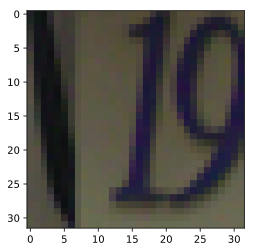

In [6]:
plt.imshow(svhn_dataset.train_x[0])

In [7]:
# Training the standard-sized DRAW model on 28x28 mnist takes a couple of days... on a gpu.
# we are gonna downsample the images to speed things up.

resize_ratio = 1.0
img_width = int(resize_ratio * img_width)
img_height = int(resize_ratio * img_height)

In [8]:
# to further expedite training, we are using smaller rnns, a smaller z dim, and fewer timesteps
draw_cell = DRAWCell(
    img_width=img_width, 
    img_height=img_height, 
    img_channels=img_channels, 
    enc_dim=800,
    z_dim=100,
    dec_dim=800, 
    read_dim=12,
    write_dim=12,
    num_timesteps=32)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [9]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

In [10]:
svhn_dataset.train_x.shape[0]

73257

In [ ]:
num_training_steps = 10000
batch_size = 100

num_epochs = num_training_steps // (x_train.shape[0] // batch_size)

training_start_time = dt.datetime.now().isoformat()

In [10]:
for epoch in range(0,num_epochs):
    clear_output(wait=True)
    
    epoch_start_time = dt.datetime.now().isoformat()
    print('training_start_time: \t {}'.format(training_start_time))
    print('epoch_start_time: \t {}\n'.format(epoch_start_time))
    
    # each epoch, get iterator over batches in the dataset.
    # svhn_dataset.get_iterator() will shuffle the dataset before returning a new iterator.
    iterator_ = svhn_dataset.get_iterator(batch_size=batch_size)
    
    for idx in range(0, svhn_dataset.train_x.shape[0], batch_size):
        imgs, labels = next(iterator_)
        elbo, gradnorm = draw_cell.train(sess, imgs)
        if idx == 0 or (idx >= 1000 and (idx % 1000 == 0)):
            print('Epoch {}, idx {}..... ELBO: {}.... GRADNORM {}'.format(epoch, idx, elbo, gradnorm))

Epoch 0, idx 0..... ELBO: -2836.37353515625.... GRADNORM 475.0
Epoch 0, idx 1000..... ELBO: -2079.13525390625.... GRADNORM 457.349365234375
Epoch 0, idx 2000..... ELBO: -2003.5185546875.... GRADNORM 429.42449951171875
Epoch 0, idx 3000..... ELBO: -1986.9569091796875.... GRADNORM 396.3580322265625
Epoch 0, idx 4000..... ELBO: -2015.491455078125.... GRADNORM 445.00140380859375
Epoch 0, idx 5000..... ELBO: -1989.2518310546875.... GRADNORM 413.9130554199219
Epoch 0, idx 6000..... ELBO: -1974.895263671875.... GRADNORM 394.96966552734375
Epoch 0, idx 7000..... ELBO: -1932.908935546875.... GRADNORM 356.7450866699219
Epoch 0, idx 8000..... ELBO: -1945.7423095703125.... GRADNORM 381.59051513671875
Epoch 0, idx 9000..... ELBO: -1942.875732421875.... GRADNORM 381.3498229980469
Epoch 0, idx 10000..... ELBO: -1950.73388671875.... GRADNORM 335.28900146484375
Epoch 0, idx 11000..... ELBO: -1875.2918701171875.... GRADNORM 391.9751281738281
Epoch 0, idx 12000..... ELBO: -1931.192138671875.... GRADNORM 

KeyboardInterrupt: 

In [11]:
output_sequence = draw_cell.sample(sess, num_imgs=8)

In [12]:
list_ = []
for i in range(0,draw_cell.num_timesteps,8):
    img = output_sequence[:,i,:,:,:]
    list_.append(img)
    
sequences = np.concatenate(list_, axis=2)

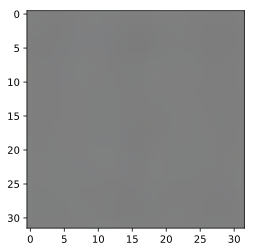

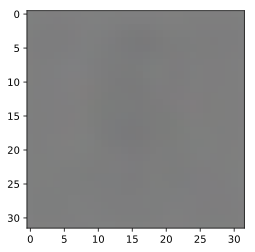

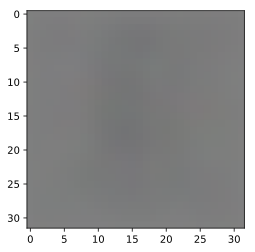

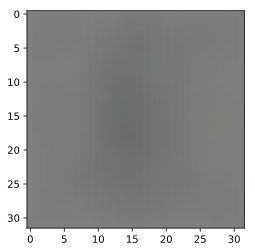

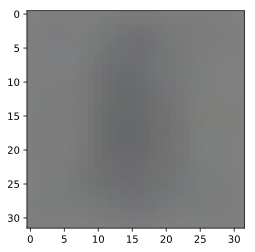

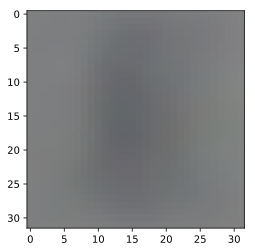

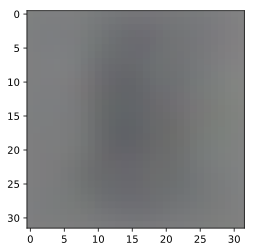

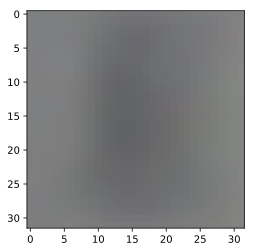

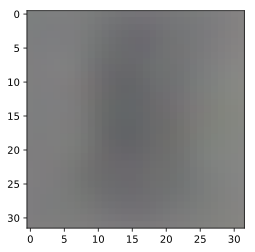

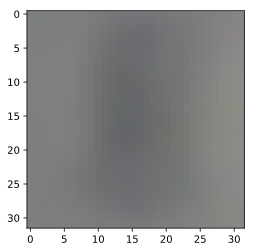

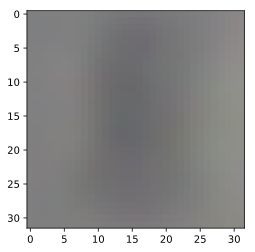

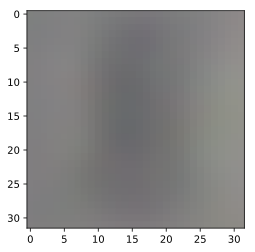

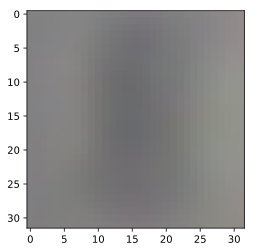

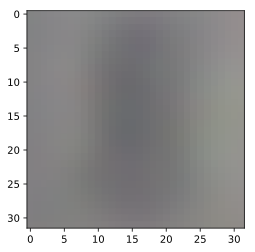

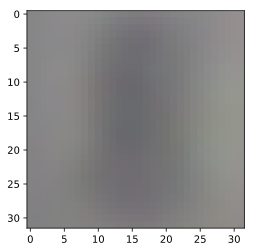

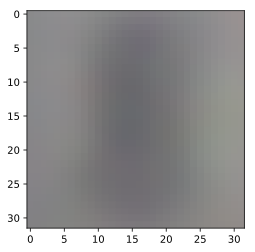

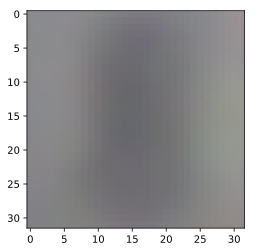

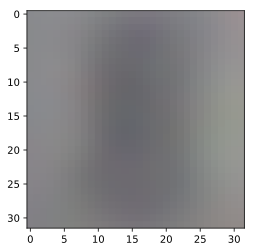

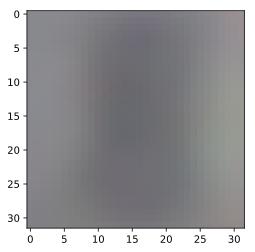

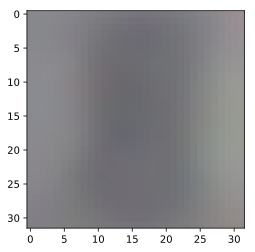

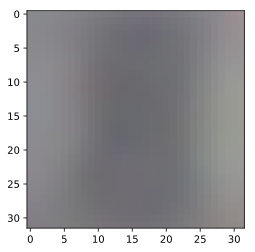

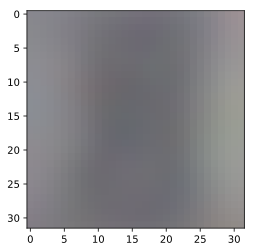

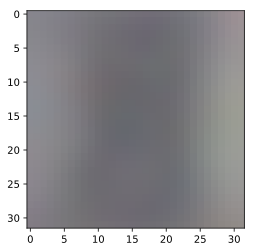

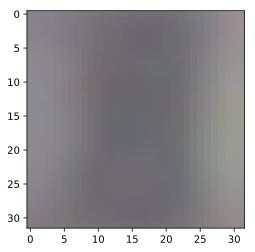

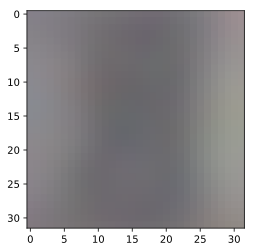

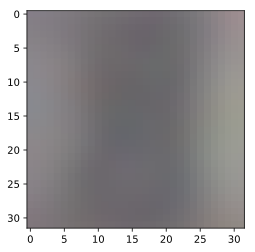

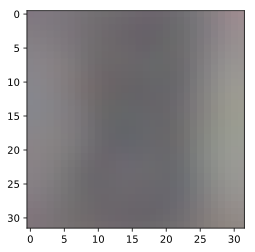

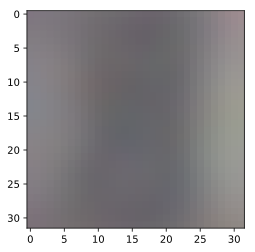

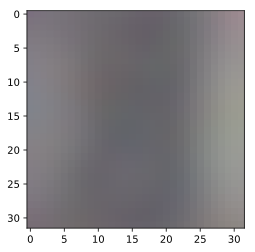

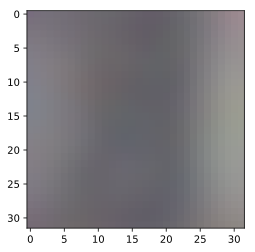

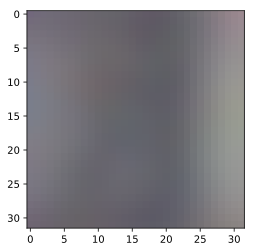

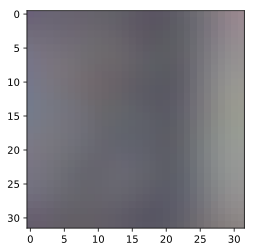

In [13]:
for i in range(0, draw_cell.num_timesteps):
    plt.imshow(output_sequence[0,i,:,:,:])
    plt.show()

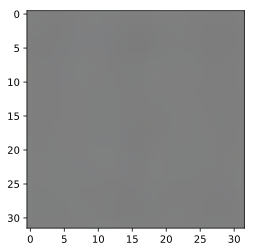

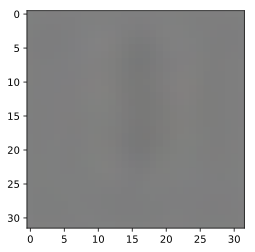

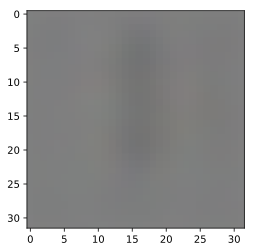

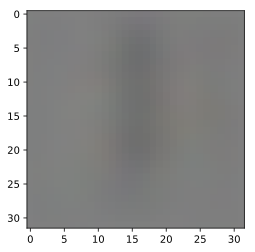

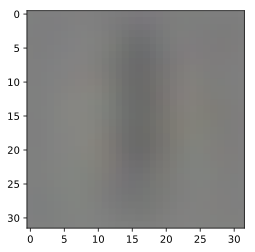

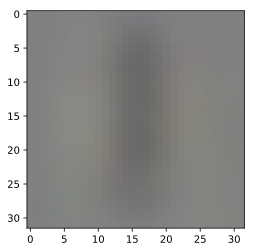

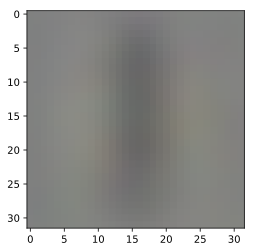

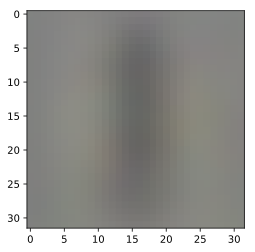

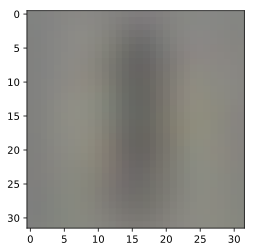

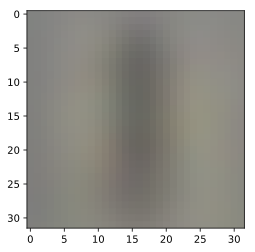

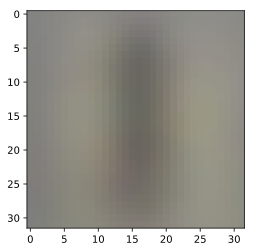

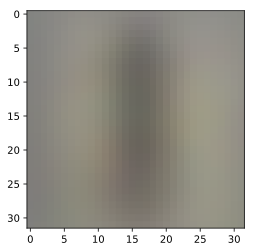

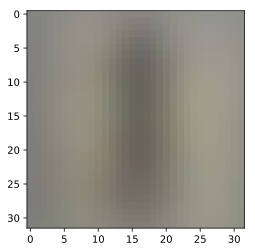

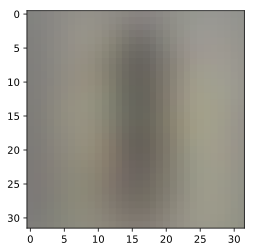

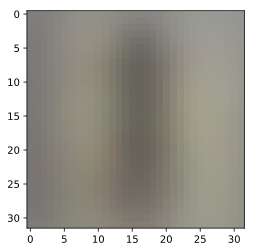

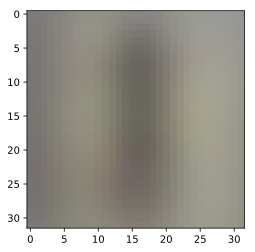

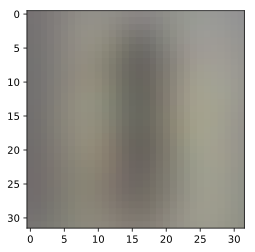

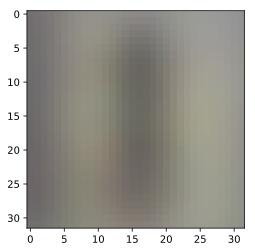

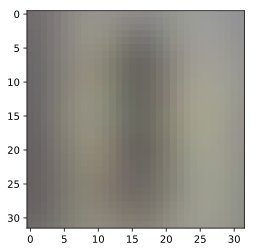

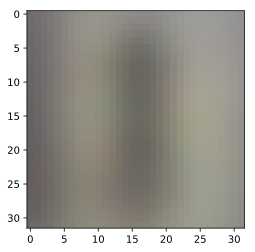

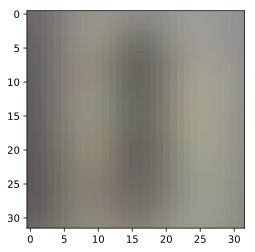

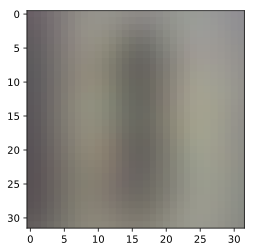

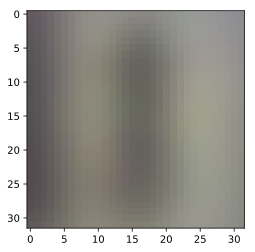

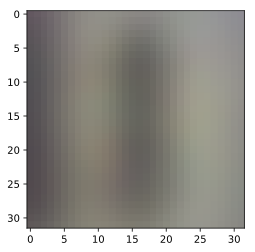

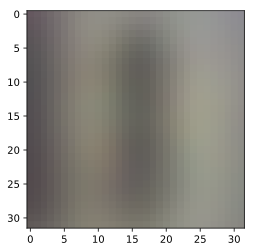

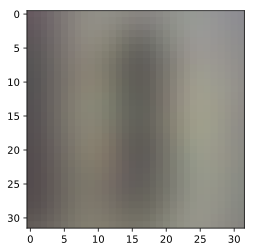

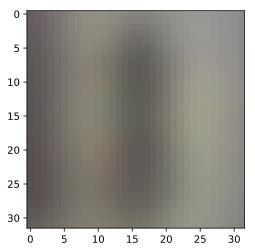

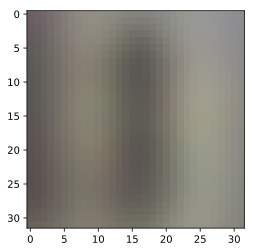

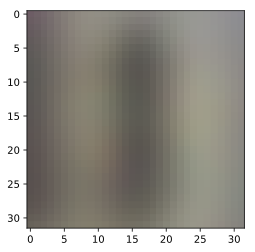

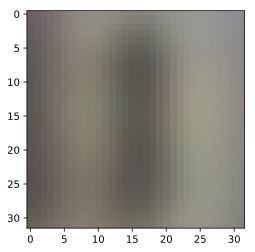

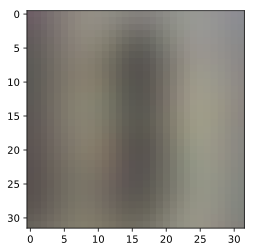

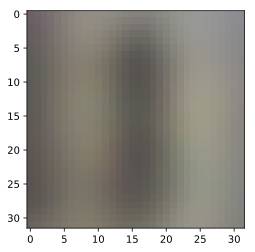

In [14]:
for i in range(0, draw_cell.num_timesteps):
    plt.imshow(output_sequence[-1,i,:,:,:])
    plt.show()

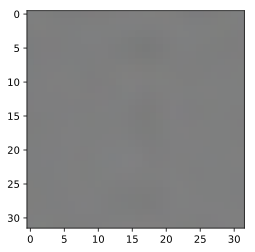

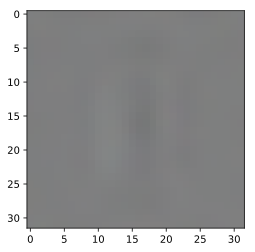

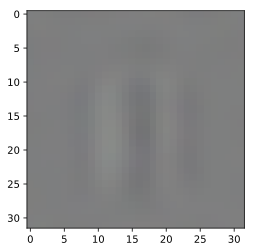

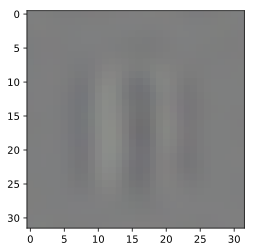

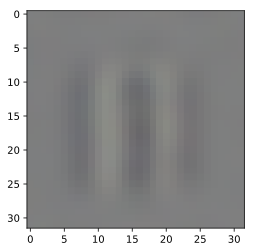

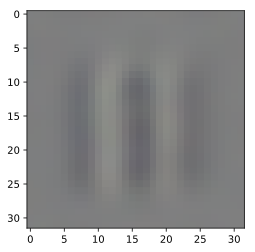

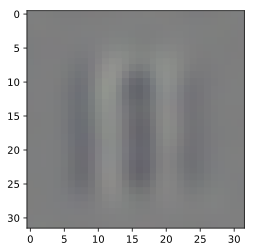

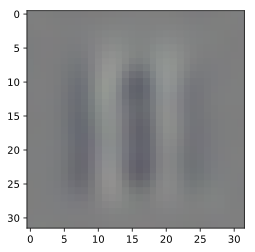

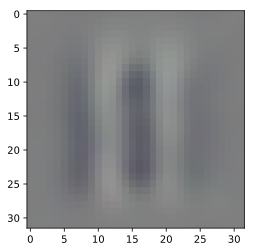

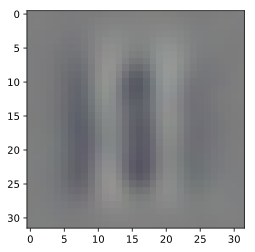

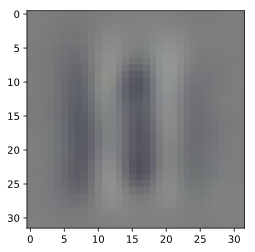

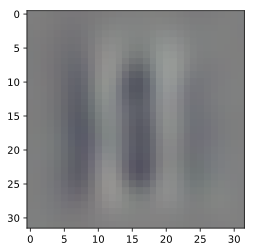

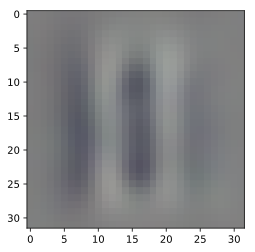

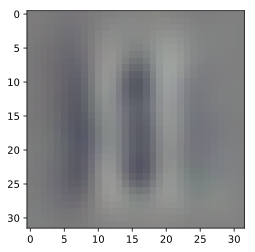

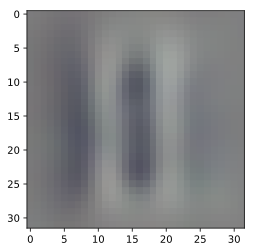

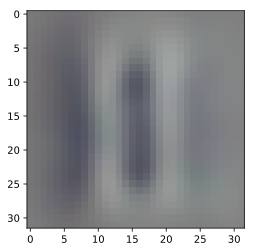

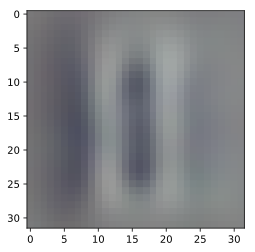

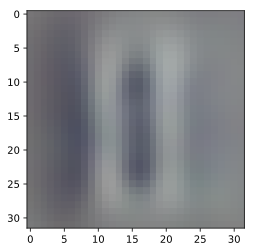

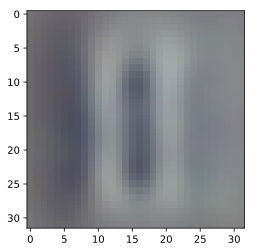

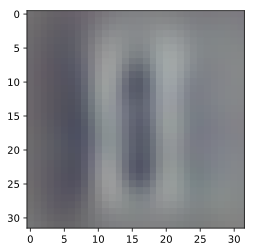

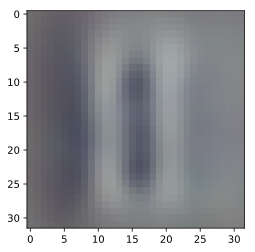

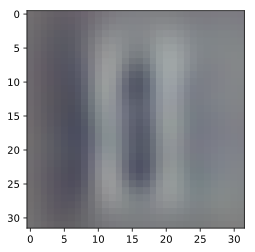

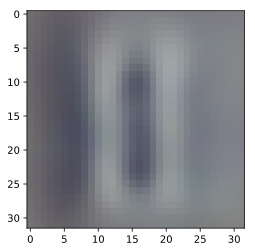

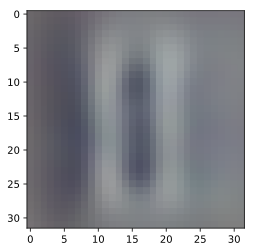

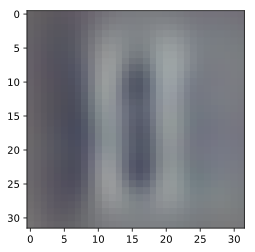

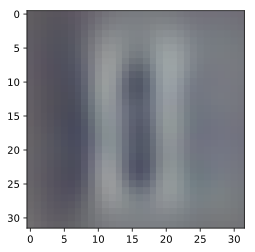

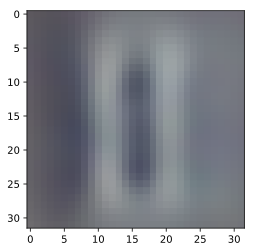

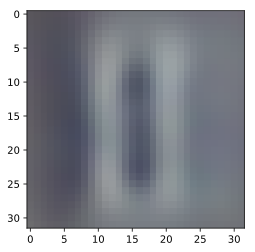

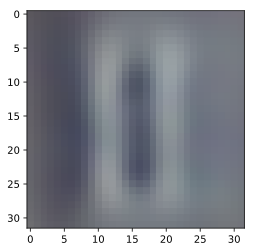

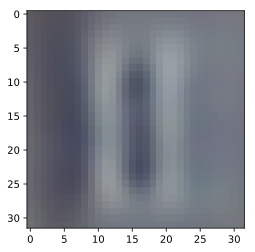

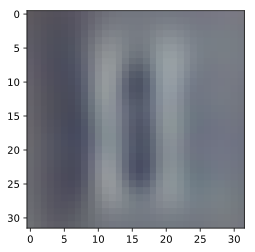

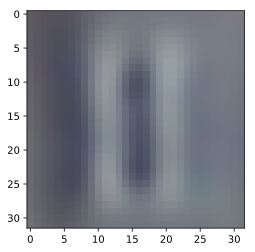

In [15]:
for i in range(0, draw_cell.num_timesteps):
    plt.imshow(output_sequence[1,i,:,:,:])
    plt.show()

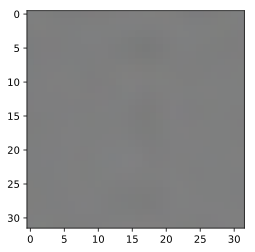

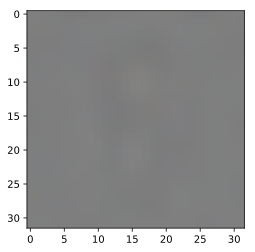

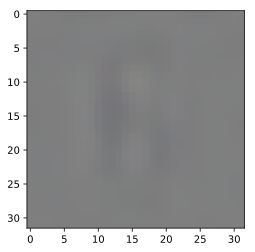

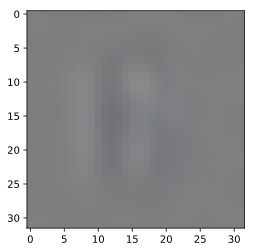

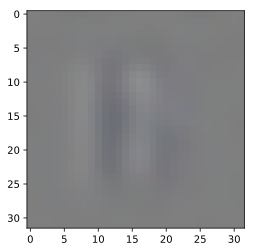

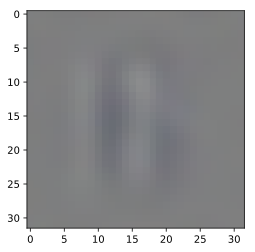

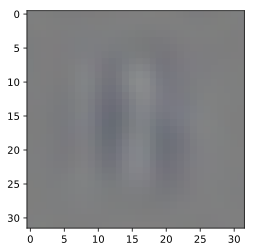

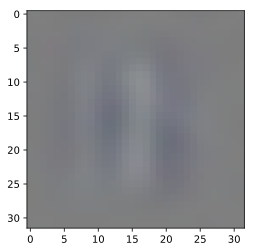

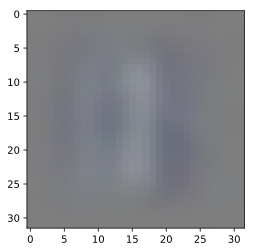

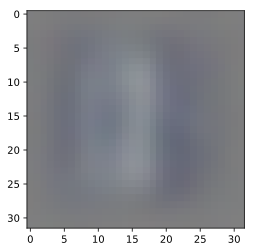

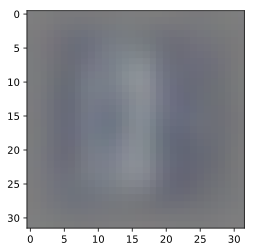

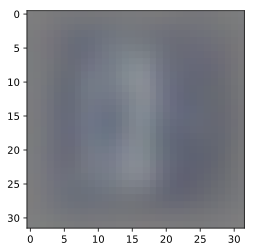

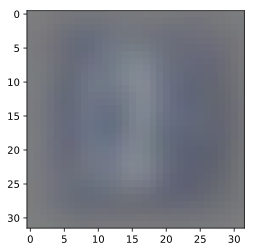

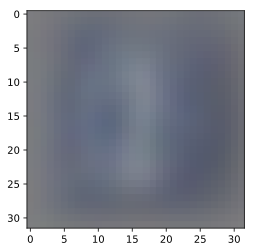

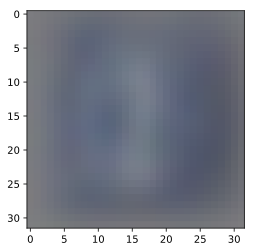

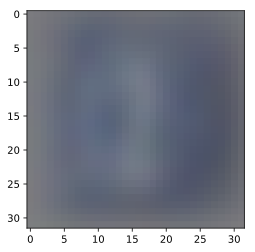

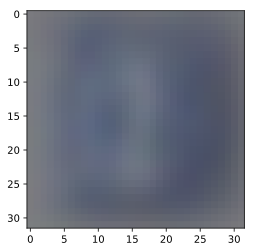

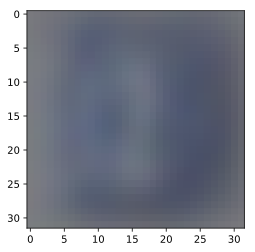

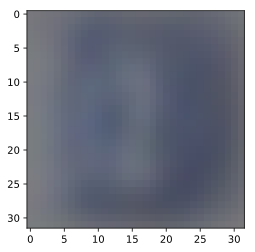

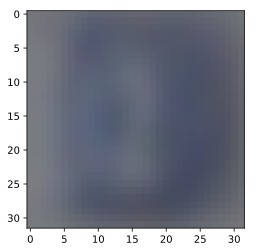

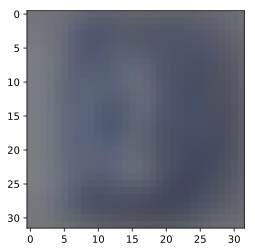

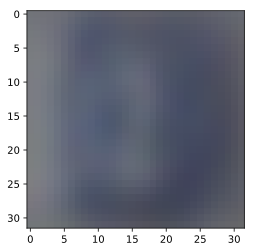

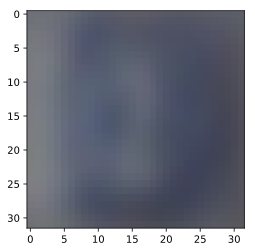

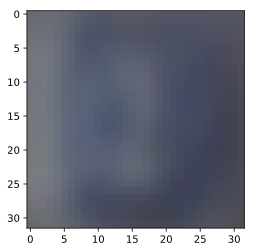

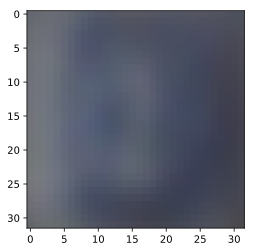

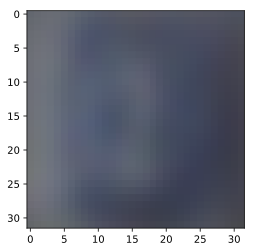

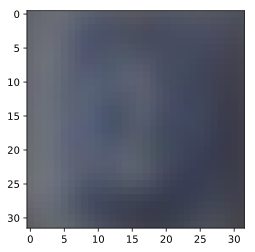

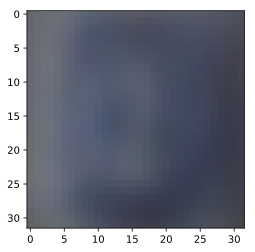

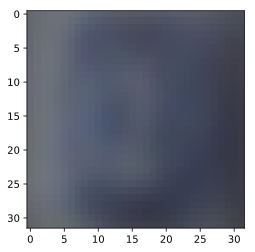

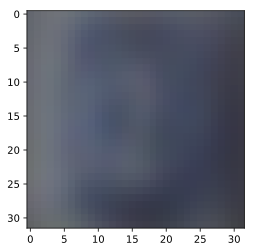

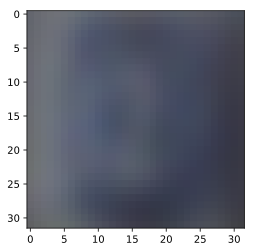

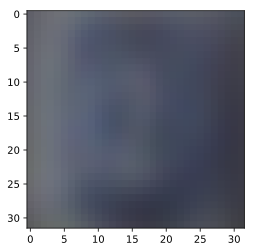

In [16]:
for i in range(0, draw_cell.num_timesteps):
    plt.imshow(output_sequence[2,i,:,:,:])
    plt.show()

In [ ]:
output_sequence = draw_cell.reconstruct(sess, imgs)

In [ ]:
plt.imshow(imgs[0,:,:,:])

In [ ]:
plt.imshow(output_sequence[0,-1,:,:,:])